Importing libraries

In [3]:
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy import stats
from scipy import sparse
import anndata as ad
import scanpy as sc
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
import statsmodels.api as sm
import scrublet as scr
import warnings
from scipy import interpolate

<H1>Loading Data: Total annotated object without dying cells</H1>

Getting the python annotated object

In [4]:
ann_object_nodying = sc.read(filename='dades/48h/ann_object_withoutdyingcells.h5ad')
ann_object_nodying.shape

(5316, 32285)

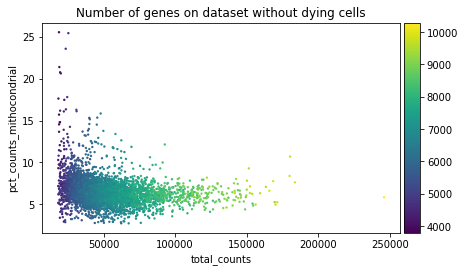

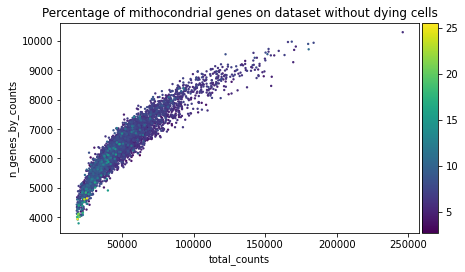

In [5]:
# Visualizing the filtered dataset.
sc.pl.scatter(ann_object_nodying, x='total_counts', y='pct_counts_mithocondrial', color='n_genes_by_counts', title='Number of genes on dataset without dying cells')
sc.pl.scatter(ann_object_nodying, x='total_counts', y='n_genes_by_counts', color='pct_counts_mithocondrial', title='Percentage of mithocondrial genes on dataset without dying cells')

<H1>NO DYING CELLS: Normalization to cell space and variance stabilization</H1>

https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1

In [6]:
warnings.filterwarnings("ignore")
# Genes selection by highly variable genes (anndata not normalized)
ann_object_nodying_hvg = ann_object_nodying.copy()
sc.pp.highly_variable_genes(ann_object_nodying_hvg, flavor='seurat_v3', n_top_genes=3000) #Expects logarithmized data, except when flavor='seurat_v3'/'seurat_v3_paper', in which count data is expected.
#Normalization to cell space
ann_object_nodying_norm = ann_object_nodying_hvg.copy()
sc.pp.normalize_total(ann_object_nodying_norm)
ann_object_nodying_norm.obs["total_counts_normalized"] = ann_object_nodying_norm.X.sum(axis=1).A1

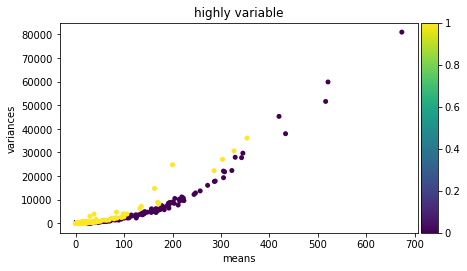

In [7]:
sc.pl.scatter(ann_object_nodying_norm, x='means', y='variances', color='highly_variable', size=100)

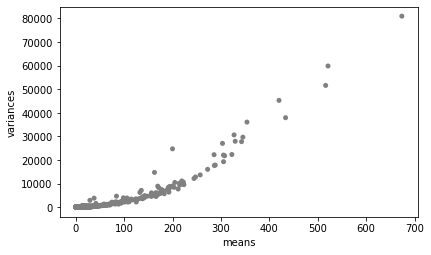

In [8]:
sc.pl.scatter(ann_object_nodying_norm, x='means', y='variances', size=100)

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html

It seems that when the cells with more representation of genes in mean, more variance of the total counts by genes is observed, so it creates a trend with the high variance.
But in the plot, we can also observe that the highly variable genes are located on the cells with less representation... (TODO: REVISAR!!!)

<H2>Variance Stabilization. Detrending the variance</H2>

<H3>Detrend of the variance using bins</H3>

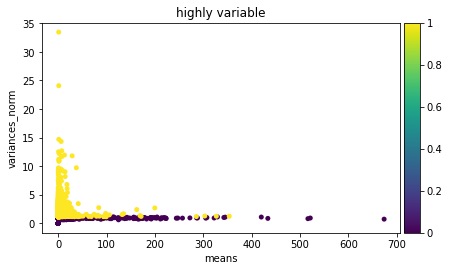

In [9]:
sc.pl.scatter(ann_object_nodying_norm, x='means', y='variances_norm', color='highly_variable', size=100)
#PCA amb dim seleccionades . es pot eliminar els gens o utilitzar la pca amb la opcio de scanpy de highly_variable_genes
#greedplot amb highlights de la pca

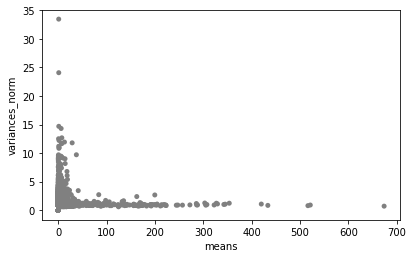

In [10]:
sc.pl.scatter(ann_object_nodying_norm, x='means', y='variances_norm', size=100)


<H3>Detrend of the variance using splines with n knots. Defining functions.</H3>

In [11]:
def fd_optimal_bins(data: np.array) -> int:
    """ The Freedman-Diaconis rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    
    p25, p75 = np.percentile(data, [25, 75])

    width = 2. * (p75 - p25)/n**(1./3)
    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

In [12]:
def calculate_mode(x):
    x = x.fillna(0.0)
    if len(x)>1:
        try:
            hist, bins_edges = np.histogram(x, bins=fd_optimal_bins(x))
        except:
            hist, bins_edges = np.histogram(x)
        return (bins_edges[np.argmax(hist)] + bins_edges[np.argmax(hist)+1]) / 2
    elif len(x)==1:
        return x[0]
    else:
        return 0

In [13]:
def get_knots_statistics_df(ann_object, n_knots, variance_attribute):
    #Generem bins a partir del numero knots indicat
    n, bins_knots = np.histogram(ann_object.var["means"], bins=n_knots)
    #Generem un df amb els bins dels knots
    knots_df = pd.DataFrame({'knot':list(range(1,len(bins_knots)+1)), 'means_knot': bins_knots})
    #Generem un df amb els estadistics de la variança a estabilitzar
    variances_df = pd.DataFrame({'means':ann_object.var["means"], 'variances':ann_object.var[variance_attribute]})
    variances_df['knot'] = np.digitize(ann_object.var["means"], bins_knots)
    statistics_df = variances_df.groupby(['knot']).agg(
                                                    variances_mean=pd.NamedAgg(column="variances", aggfunc="mean"),                                                
                                                    variances_trimmedmean=pd.NamedAgg(column="variances", aggfunc=lambda x: stats.trim_mean(x, 0.25)),
                                                    variances_mode=pd.NamedAgg(column="variances", aggfunc=lambda x: calculate_mode(x))
                                                   )
    #Fusionem dfs per aconseguir un df amb els estadistics de la variança a estabilitzar per knot
    knots_statistics_df = knots_df.merge(statistics_df, on=['knot'])
    return knots_statistics_df

In [14]:
from scipy.interpolate import BSpline

def calculate_Bspline(ann_object, n_knots, variance_attribute, smoothing_param, k_param, y_line):
    #Getting the knots bins and the statistics associated.
    knots_statistics_df = get_knots_statistics_df(ann_object, n_knots, variance_attribute)
    #Finding the B-Spline representation of a 1-D curve. Given the set data points (x[i], y[i]) determine a smooth spline approximation of degree k on the interval xb <= x <= xe.
    #Obtenim els coeficients de la B-spline: Com a entrada reb els knots calculats i un estadistic per a calcular el B-spline, la smoothing condition 0 (interpolating, no weights,???) i el grau del fitteig de l'spline=1
    if k_param:
        spline = interpolate.splrep(np.array(knots_statistics_df['means_knot']),np.array(knots_statistics_df['variances_mode']), s=smoothing_param, k=k_param)
    else:
        spline = interpolate.splrep(np.array(knots_statistics_df['means_knot']),np.array(knots_statistics_df['variances_mode']), s=smoothing_param)
    #Given the knots and coefficients of a B-spline representation, evaluate the value of the smoothing polynomial and its derivatives.
    y2 = interpolate.splev(ann_object.var["means"], spline)

    #Donats els coeficients de la B-spline, evaluem una línea (és una ajuda per al plot)
    y = BSpline(*spline)(y_line)
    return knots_statistics_df, y2, y

In [15]:
def plotting_Bspline(ann_object, knots_statistics_df, y2, y, variance_attribute, ann_object_def, y_line, y_lim_a=None, y_lim_b=None):
    plt.figure()
    plt.scatter(ann_object.var["means"], ann_object.var[variance_attribute], color="green", s=1)
    plt.scatter(knots_statistics_df['means_knot'], knots_statistics_df['variances_mode'], color="blue", s=10)
    plt.plot(y_line, y, color='blue') #linea, ajuda per al plot
    plt.scatter(ann_object.var["means"], y2, color="orange")
    if y_lim_a!=None: plt.ylim(y_lim_a, y_lim_b)
    #plt.title(f'B-spline (orange points) of variances on {ann_object_def} cell space (green points) using calculated statistics (blue points and line)')
    plt.show()

In [16]:
def plotting_detrends(ann_object, y2, variance_attribute, ann_object_def=""):
    figure, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    figure.suptitle(f"Variance detrend on {ann_object_def} cell space")
    ax1.scatter(ann_object.var["means"].to_list(), ann_object.var[f"{variance_attribute}_norm"], s=1)
    ax1.set_title('Bins detrend')
    ax1.set_xlabel('means')
    ax1.set_ylabel('Detrend variance')
    ax2.scatter(ann_object.var["means"].to_list(), ann_object.var[variance_attribute] - y2, s=1)
    ax2.set_title('B-splines detrend')
    ax2.set_xlabel('means')
    ax2.set_ylabel('Detrend variance')
    figure.show()

In [17]:
def plotting_comparision_detrends(ann_object, y2, variance_attribute, ann_object_def=""):
    plt.figure()
    plt.title(f'Bins vs B-splines variance detrend on {ann_object_def} cell space')
    plt.scatter(ann_object.var[f"{variance_attribute}_norm"], ann_object.var[variance_attribute] - y2, s=1)
    plt.xlabel('Bins variance detrend')
    plt.ylabel('B-splines variance detrend')
    plt.show()

<H3>BSplines detrend of the variance, using splines with n knots.</H3>

In [18]:
norm_y_line = np.linspace(0,700,100)
norm_knots_statistics_df, norm_y2_10, norm_y_10 = calculate_Bspline(ann_object=ann_object_nodying_norm, n_knots=10, variance_attribute="variances", smoothing_param=0, k_param=1, y_line=norm_y_line)

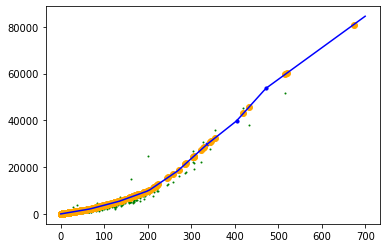

In [19]:
plotting_Bspline(ann_object_nodying_norm, norm_knots_statistics_df, norm_y2_10, norm_y_10, "variances", ann_object_def="normalized", y_line=norm_y_line)

Al fer-ho en el espai normal i no en el logaritmic veiem qui hi ha moltissima dispersió i per això el smoothing no acaba de funcionar, i no acabem de fer el detrend de manera correcta.

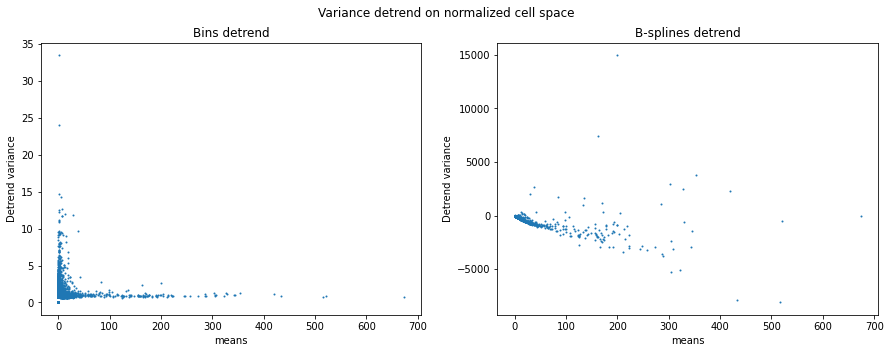

In [20]:
plotting_detrends(ann_object_nodying_norm, norm_y2_10, "variances", ann_object_def="normalized")

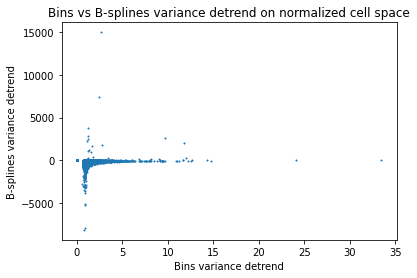

In [21]:
plotting_comparision_detrends(ann_object_nodying_norm, norm_y2_10, "variances", ann_object_def="normalized")

S'observen petites diferències entre el mètodo automàtic i el manual degut segurament a la dispersió que comentavem.

<H1>NO DYING CELLS: Lognormalization to cell space and variance stabilization</H1>

In [22]:
ann_object_nodying_norm_log = ann_object_nodying.copy()
sc.pp.normalize_total(ann_object_nodying_norm_log)
ann_object_nodying_norm_log.obs["total_counts_normalized"] = ann_object_nodying_norm_log.X.sum(axis=1).A1
sc.pp.log1p(ann_object_nodying_norm_log)
ann_object_nodying_norm_log.obs["total_counts_normalized_log"] = ann_object_nodying_norm_log.X.sum(axis=1).A1

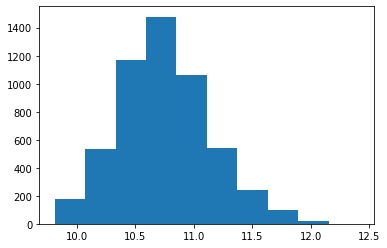

In [23]:
hist = plt.hist(ann_object_nodying_norm_log.obs["log1p_total_counts"].values)

In [24]:
warnings.filterwarnings("ignore")
sc.pp.highly_variable_genes(ann_object_nodying_norm_log, n_top_genes=3000)

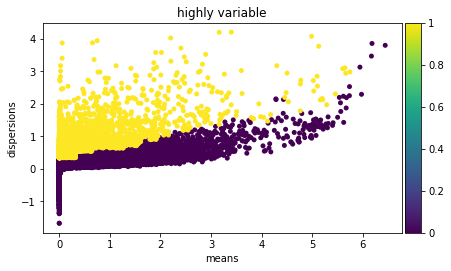

In [25]:
sc.pl.scatter(ann_object_nodying_norm_log, x='means', y='dispersions', color='highly_variable', size=100)

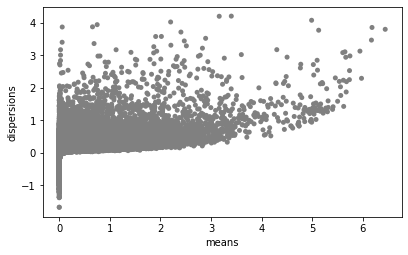

In [26]:
sc.pl.scatter(ann_object_nodying_norm_log, x='means', y='dispersions', size=100)

<H2>Variance Stabilization. Detrending the variance</H2>

<H3>Detrend of the variance using BINS</H3>

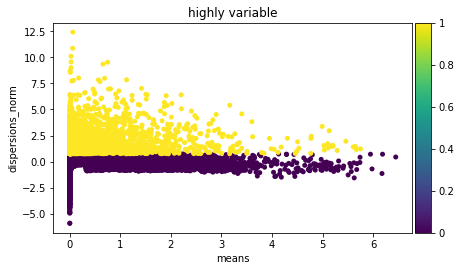

In [27]:
sc.pl.scatter(ann_object_nodying_norm_log, x='means', y='dispersions_norm', color='highly_variable', size=100)
#PCA amb dim seleccionades . es pot eliminar els gens o utilitzar la pca amb la opcio de scanpy de highly_variable_genes
#greedplot amb highlights de la pca

<H3>BSplines detrend, using splines with n equidistants knots</H3>

In [28]:
lognorm_y_line = np.linspace(0,6.5,10)
n_knots=100
lognorm_knots_statistics_df, lognorm_y2_10, lognorm_y_10 = calculate_Bspline(ann_object=ann_object_nodying_norm_log, n_knots=n_knots, variance_attribute="dispersions", smoothing_param=1, k_param=None, y_line=lognorm_y_line)

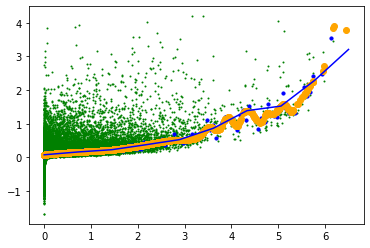

In [29]:
plotting_Bspline(ann_object_nodying_norm_log, lognorm_knots_statistics_df, lognorm_y2_10, lognorm_y_10, "dispersions", ann_object_def="log-normalized", y_line=lognorm_y_line)

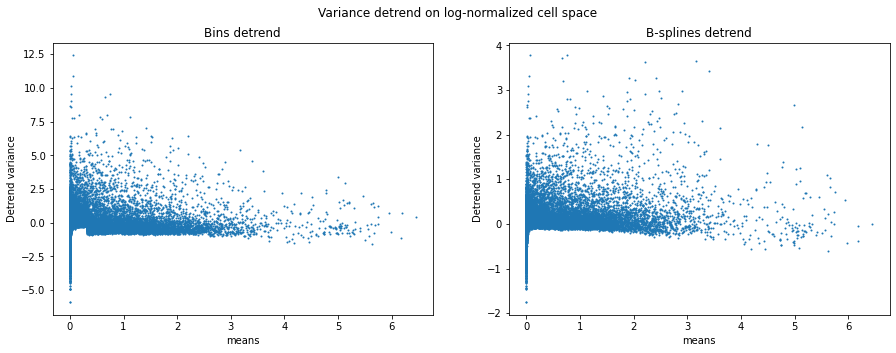

In [30]:
plotting_detrends(ann_object_nodying_norm_log, lognorm_y2_10, "dispersions", ann_object_def="log-normalized")

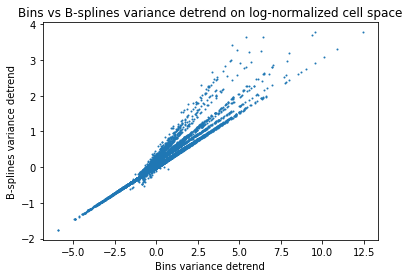

In [31]:
plotting_comparision_detrends(ann_object_nodying_norm_log, lognorm_y2_10, "dispersions", ann_object_def="log-normalized")

S'observen diferències entre el mètode automàtic i el manual.

<H3>BSplines Detrend, using splines with uniform distributed knots</H3>

In [32]:
knots = []
for i in range(n_knots):
    knots.append(ann_object_nodying_norm_log.var["means"][np.argsort(ann_object_nodying_norm_log.var["means"])].values[i*int(len(ann_object_nodying_norm_log.var["means"])/n_knots)])
knots.append(max(ann_object_nodying_norm_log.var["means"]))
knots = sorted(set(knots))

lognorm_manuknots_statistics_df, lognorm_manuknots_y2_10, lognorm_manuknots_y_10 = calculate_Bspline(ann_object=ann_object_nodying_norm_log, n_knots=knots, variance_attribute="dispersions", smoothing_param=1, k_param=None, y_line=lognorm_y_line)

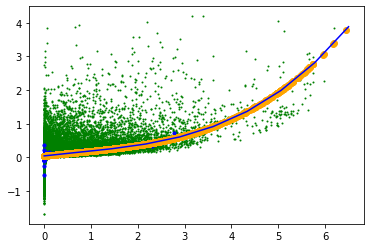

In [33]:
plotting_Bspline(ann_object_nodying_norm_log, lognorm_manuknots_statistics_df, lognorm_manuknots_y2_10, lognorm_manuknots_y_10, "dispersions", ann_object_def="log-normalized", y_line=lognorm_y_line)

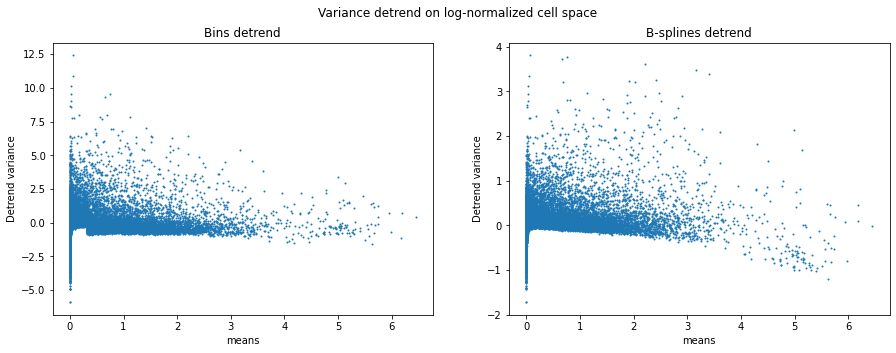

In [34]:
plotting_detrends(ann_object_nodying_norm_log, lognorm_manuknots_y2_10, "dispersions", ann_object_def="log-normalized")

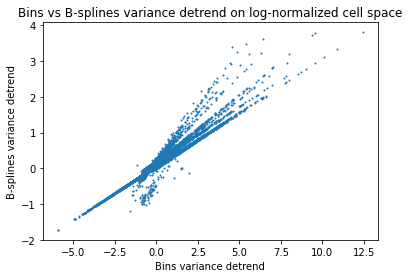

In [35]:
plotting_comparision_detrends(ann_object_nodying_norm_log, lognorm_manuknots_y2_10, "dispersions", ann_object_def="log-normalized")

#TODO:  puc fer-ho amb el log per veure que realment el log1p funciona per si s'hi afegeix un paràmetre perque evitem el 0

<H1> NO DYING CELLS: Feature Selection on lognormalized cell space using BSPlines detrend using splines</H1>

In [36]:
detrend = (ann_object_nodying_norm_log.var["dispersions"] - lognorm_y2_10)
detrend = detrend.fillna(0.0)
feature_dispersion_detrend_order = np.argsort(detrend.values) # index d'ordenació segons ordre dels valors detrend (minim a màxim)

feature_selected = (ann_object_nodying_norm_log.var["dispersions"] - lognorm_y2_10)[feature_dispersion_detrend_order[::-1]][0:1000] # es seleccionen les 1000 característiques amb major dispersió ajustada (valors detrens invertits: màxim a mínim)

detrend_auto = ann_object_nodying_norm_log.var["dispersions_norm"]
detrend_auto = detrend_auto.fillna(0.0)
feature_dispersion_detrend_auto_order = np.argsort(detrend_auto.values)

feature_selected_auto = (ann_object_nodying_norm_log.var["dispersions_norm"])[feature_dispersion_detrend_order[::-1]][0:1000]

#diferencias entre elementos de la primera lista respecto a la segunda lista.
print ([element for element in list(feature_selected.keys()) if element not in feature_selected_auto.keys()])
#diferencias entre elementos de la segunda lista respecto a la primera lista.
print ([element for element in list(feature_selected_auto.keys()) if element not in feature_selected.keys()])

[]
[]


In [37]:
ann_object_feature_selected_nodying = ann_object_nodying_norm_log.copy()
ann_object_feature_selected_nodying = ann_object_feature_selected_nodying[:, feature_selected.keys()]
df_X_matrix = pd.DataFrame.sparse.from_spmatrix(ann_object_feature_selected_nodying.X)
X_matrix = df_X_matrix.to_numpy()

<H3> Selecting the PCA number, with a permutation test</H3>

In [38]:
def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values
        
    return X_aux.to_numpy()

In [39]:
from sklearn.decomposition import TruncatedSVD, PCA
clf = PCA()
Xpca = clf.fit(X_matrix)
original_variance = clf.explained_variance_ratio_
N_permutations = 100
variance = np.zeros((N_permutations, len(df_X_matrix.columns)))
for i in range(N_permutations):
    X_aux = de_correlate_df(df_X_matrix)
    clf.fit(X_aux)
    variance[i, :] = clf.explained_variance_ratio_
average_permuted_variance = np.mean(variance, axis=0)

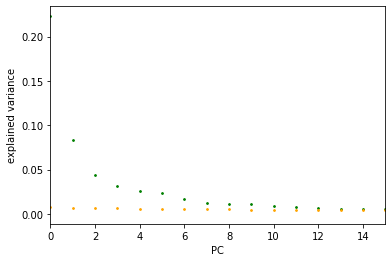

In [40]:
plt.figure()
plt.scatter([i for i in range(len(df_X_matrix.columns))], original_variance, s=3, color="green")
plt.scatter([i for i in range(len(df_X_matrix.columns))], average_permuted_variance, s=3, color="orange")
plt.xlim(0,15)
plt.xlabel('PC')
plt.ylabel('explained variance')
plt.show()

#TODO: utilitzar elbow method per acabar d'escollir? O d'aquesta manera més manual?

<H3>Principal Component Analysis coordinates and Nearest Neighbor distance matrix</H3>

In [41]:
sc.pp.pca(ann_object_feature_selected_nodying, n_comps = 13)
sc.pp.neighbors(ann_object_feature_selected_nodying, n_pcs=ann_object_feature_selected_nodying.varm['PCs'].shape[1])
sc.tl.umap(ann_object_feature_selected_nodying)

2024-09-23 22:53:00.411454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-23 22:53:00.411472: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


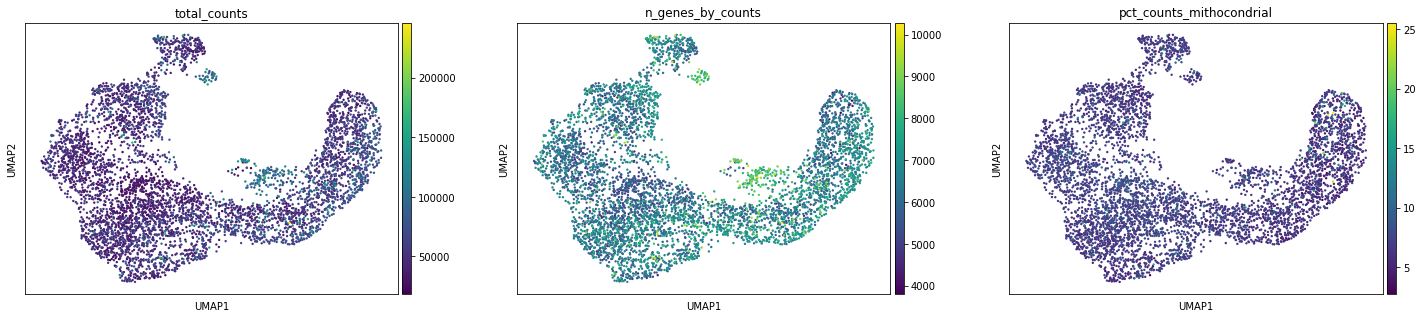

In [42]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
for i, measure in enumerate(["total_counts","n_genes_by_counts","pct_counts_mithocondrial"]):
    sc.pl.umap(ann_object_feature_selected_nodying, color=measure, ax=axs[i], show=False)
plt.show()

<H1> NO DYING, NO DOUBLETS: on lognorm space </H1>

In [43]:
ann_object_cleaned = sc.read(filename='dades/48h/ann_object_withoutdyingcells_withoutdoubletcells_withoutscrubletdoubletcells.h5ad')
ann_object_cleaned.shape

(4843, 32285)

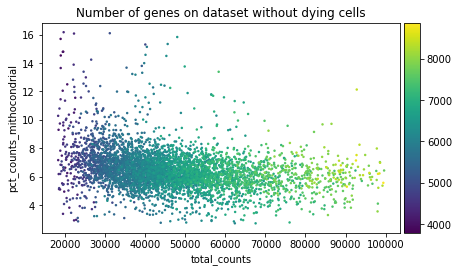

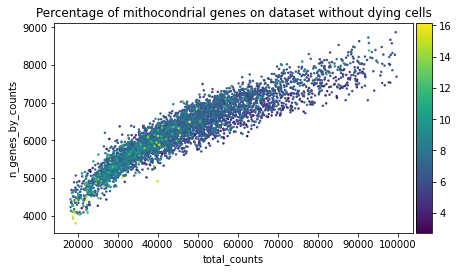

In [44]:
# Visualizing the filtered dataset.
sc.pl.scatter(ann_object_cleaned, x='total_counts', y='pct_counts_mithocondrial', color='n_genes_by_counts', title='Number of genes on dataset without dying cells')
sc.pl.scatter(ann_object_cleaned, x='total_counts', y='n_genes_by_counts', color='pct_counts_mithocondrial', title='Percentage of mithocondrial genes on dataset without dying cells')

<H1>Lognormalization to cell space and variance stabilization</H1>

In [45]:
ann_object_cleaned_norm_log = ann_object_cleaned.copy()
sc.pp.normalize_total(ann_object_cleaned_norm_log)
ann_object_cleaned_norm_log.obs["total_counts_normalized"] = ann_object_cleaned_norm_log.X.sum(axis=1).A1
sc.pp.log1p(ann_object_cleaned_norm_log)
ann_object_cleaned_norm_log.obs["total_counts_normalized_log"] = ann_object_cleaned_norm_log.X.sum(axis=1).A1

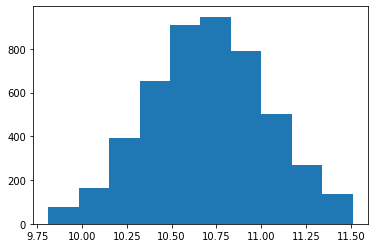

In [46]:
hist = plt.hist(ann_object_cleaned_norm_log.obs["log1p_total_counts"].values)

In [47]:
warnings.filterwarnings("ignore")
sc.pp.highly_variable_genes(ann_object_cleaned_norm_log, n_top_genes=3000)

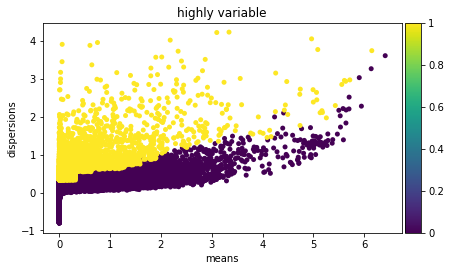

In [48]:
sc.pl.scatter(ann_object_cleaned_norm_log, x='means', y='dispersions', color='highly_variable', size=100)

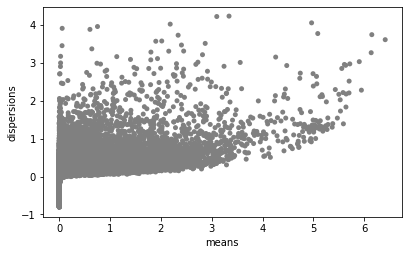

In [49]:
sc.pl.scatter(ann_object_cleaned_norm_log, x='means', y='dispersions', size=100)

<H2>Variance Stabilization. Detrending the variance</H2>

<H3>Automatic detrend of the variance</H3>

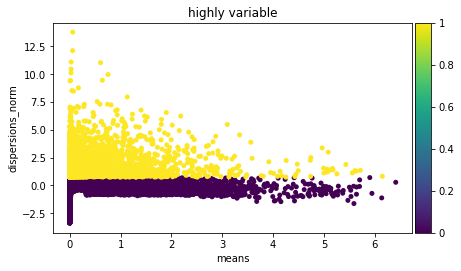

In [50]:
sc.pl.scatter(ann_object_cleaned_norm_log, x='means', y='dispersions_norm', color='highly_variable', size=100)
#PCA amb dim seleccionades . es pot eliminar els gens o utilitzar la pca amb la opcio de scanpy de highly_variable_genes
#greedplot amb highlights de la pca

<H3>Manually, using splines with n automatic knots</H3>

In [51]:
lognorm_knots_statistics_df, lognorm_y2_10, lognorm_y_10 = calculate_Bspline(ann_object=ann_object_cleaned_norm_log, n_knots=100, variance_attribute="dispersions", smoothing_param=1, k_param=None, y_line=lognorm_y_line)

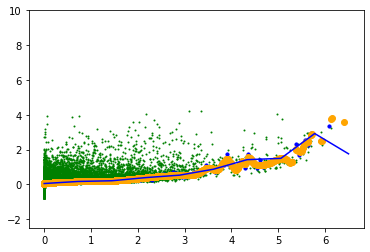

In [63]:
plotting_Bspline(ann_object_cleaned_norm_log, lognorm_knots_statistics_df, lognorm_y2_10, lognorm_y_10, "dispersions", ann_object_def="log-normalized", y_line=lognorm_y_line, y_lim_a=-2.5, y_lim_b=10)

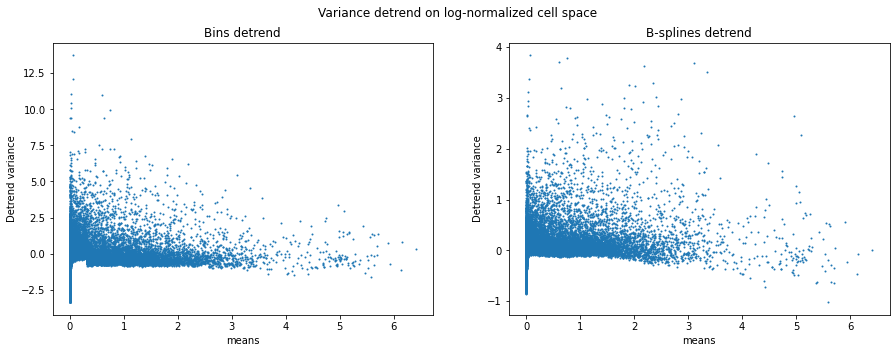

In [53]:
plotting_detrends(ann_object_cleaned_norm_log, lognorm_y2_10, "dispersions", ann_object_def="log-normalized")

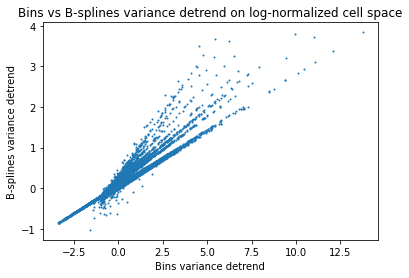

In [54]:
plotting_comparision_detrends(ann_object_cleaned_norm_log, lognorm_y2_10, "dispersions", ann_object_def="log-normalized")

S'observen diferències entre el mètode automàtic i el manual.

<H2> Feature Selection on lognormalized cell space using manual detrend using splines</H2>

In [55]:
detrend = (ann_object_cleaned_norm_log.var["dispersions"] - lognorm_y2_10)
detrend = detrend.fillna(0.0)
feature_dispersion_detrend_order = np.argsort(detrend.values)

feature_selected = (ann_object_cleaned_norm_log.var["dispersions"] - lognorm_y2_10)[feature_dispersion_detrend_order[::-1]][0:1000]
#TODO: porque hemos decidido que nos quedamos con 1000?

detrend_auto = ann_object_cleaned_norm_log.var["dispersions_norm"]
detrend_auto = detrend_auto.fillna(0.0)
feature_dispersion_detrend_auto_order = np.argsort(detrend_auto.values)

feature_selected_auto = (ann_object_cleaned_norm_log.var["dispersions_norm"])[feature_dispersion_detrend_order[::-1]][0:1000]

#diferencias entre elementos de la primera lista respecto a la segunda lista.
#print ([element for element in list(feature_selected.keys()) if element not in feature_selected_auto.keys()])
#diferencias entre elementos de la segunda lista respecto a la primera lista.
#print ([element for element in list(feature_selected_auto.keys()) if element not in feature_selected.keys()])

In [56]:
ann_object_cleaned_feature_selected = ann_object_cleaned_norm_log.copy()
ann_object_cleaned_feature_selected = ann_object_cleaned_feature_selected[:, feature_selected.keys()]
df_X_matrix = pd.DataFrame.sparse.from_spmatrix(ann_object_cleaned_feature_selected.X)
X_matrix = df_X_matrix.to_numpy()

<H3> Selecting the PCA number, with a permutation test</H3>

In [196]:
from sklearn.decomposition import TruncatedSVD, PCA
clf = PCA()
Xpca = clf.fit(X_matrix)
original_variance = clf.explained_variance_ratio_
N_permutations = 100
variance = np.zeros((N_permutations, len(df_X_matrix.columns)))
for i in range(N_permutations):
    X_aux = de_correlate_df(df_X_matrix)
    clf.fit(X_aux)
    variance[i, :] = clf.explained_variance_ratio_
average_permuted_variance = np.mean(variance, axis=0)

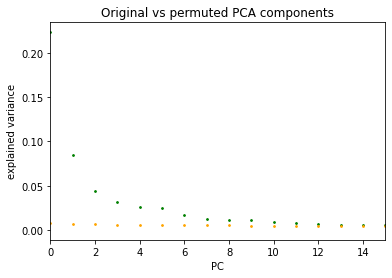

In [197]:
plt.figure()
plt.scatter([i for i in range(len(df_X_matrix.columns))], original_variance, s=3, color="green")
plt.scatter([i for i in range(len(df_X_matrix.columns))], average_permuted_variance, s=3, color="orange")
plt.xlim(0,15)
plt.title("Original vs permuted PCA components")
plt.xlabel('PC')
plt.ylabel('explained variance')
plt.show()

#TODO: utilitzar elbow method per acabar d'escollir? O d'aquesta manera més manual?

<H3>Principal Component Analysis coordinates and Nearest Neighbor distance matrix</H3>

In [57]:
sc.pp.pca(ann_object_cleaned_feature_selected, n_comps = 13)
sc.pp.neighbors(ann_object_cleaned_feature_selected, n_pcs=ann_object_cleaned_feature_selected.varm['PCs'].shape[1])
sc.tl.umap(ann_object_cleaned_feature_selected)

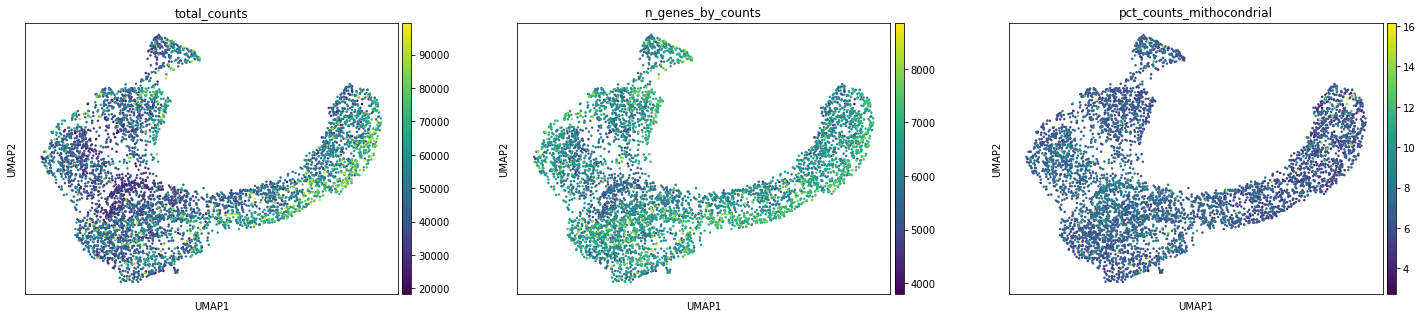

In [60]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
for i, measure in enumerate(["total_counts","n_genes_by_counts","pct_counts_mithocondrial"]):
    sc.pl.umap(ann_object_cleaned_feature_selected, color=measure, ax=axs[i], show=False)
plt.show()

<H1> Saving the cleaned and feature selected anndata</H1>

In [564]:
ann_object_cleaned_feature_selected.write_h5ad('dades/48h/ann_object_cleaned_feature_selected.h5ad')